In [4]:
import os
import tensorflow as tf
import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt

In [5]:
DATA_PATH = "/home/forvest/projects/mahdi_amin/vision/classification/rice/data"
CACHE_PATH = "/home/forvest/projects/mahdi_amin/vision/classification/rice/cache"
seed = 75
buffer_size = 7575

batch_size = 32
image_height = 128
image_width = 128
channels = 3

classes = sorted(os.listdir(DATA_PATH))

_____
_____
_____

# Preprocessing data

In [ ]:
all_image_paths = tf.data.Dataset.list_files(
    file_pattern = os.path.join(DATA_PATH, "*", "*"),
    shuffle=True,
    seed=seed,
)
total_images  = tf.data.experimental.cardinality(all_image_paths).numpy()
all_image_paths = all_image_paths.cache()

all_image_paths = all_image_paths.shuffle(buffer_size=total_images, seed=seed, reshuffle_each_iteration=False)

In [7]:
length_train = round(total_images *.7)
length_valid = round(total_images *.15)
length_test = total_images  - length_train - length_valid

print("total_images :", total_images)
print(f"train_df: {length_train}\nvalid_df: {length_valid}\ntest_df: {length_test}")

total_images : 4730
train_df: 3311
valid_df: 710
test_df: 709


In [8]:
# Splitting dataset to train, test, valid

# Training dataframe
train_image_paths = all_image_paths.take(length_train)

# Validation dataframe
valid_image_paths = all_image_paths.skip(length_train).take(length_valid)

# Testing dataframe
test_image_paths = all_image_paths.skip(length_train+length_valid)

In [9]:
# Make labels  numerical
string_lookup = tf.keras.layers.StringLookup(vocabulary=classes)

# Import images and labels 
def process_import(file_path):
    print(file_path)
    label = tf.strings.split(file_path, sep=os.path.sep)[-2]
    label = string_lookup(label) - 1 

    img = tf.io.read_file(filename=file_path)
    img = tf.io.decode_jpeg(contents=img, channels=3)
    img = tf.image.resize(images=img, size=[image_height, image_width])
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

In [10]:
# train
# Shuffling
train_df = train_image_paths.shuffle(length_train, seed=seed)

train_df = train_image_paths.map(process_import, num_parallel_calls=tf.data.AUTOTUNE)

# Batch Batch
train_df = train_df.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
train_df = train_df.prefetch(batch_size)

Tensor("args_0:0", shape=(), dtype=string)


In [11]:
# valid
# Import images and labels 
valid_df = valid_image_paths.map(process_import, num_parallel_calls=tf.data.AUTOTUNE)

# Batch Batch
valid_df = valid_df.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
valid_df = valid_df.prefetch(batch_size)

Tensor("args_0:0", shape=(), dtype=string)


In [12]:
# Test
# Import images and labels 
test_df = test_image_paths.map(process_import, num_parallel_calls=tf.data.AUTOTUNE)

# Batch Batch
test_df = test_df.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
test_df = test_df.prefetch(batch_size)

Tensor("args_0:0", shape=(), dtype=string)


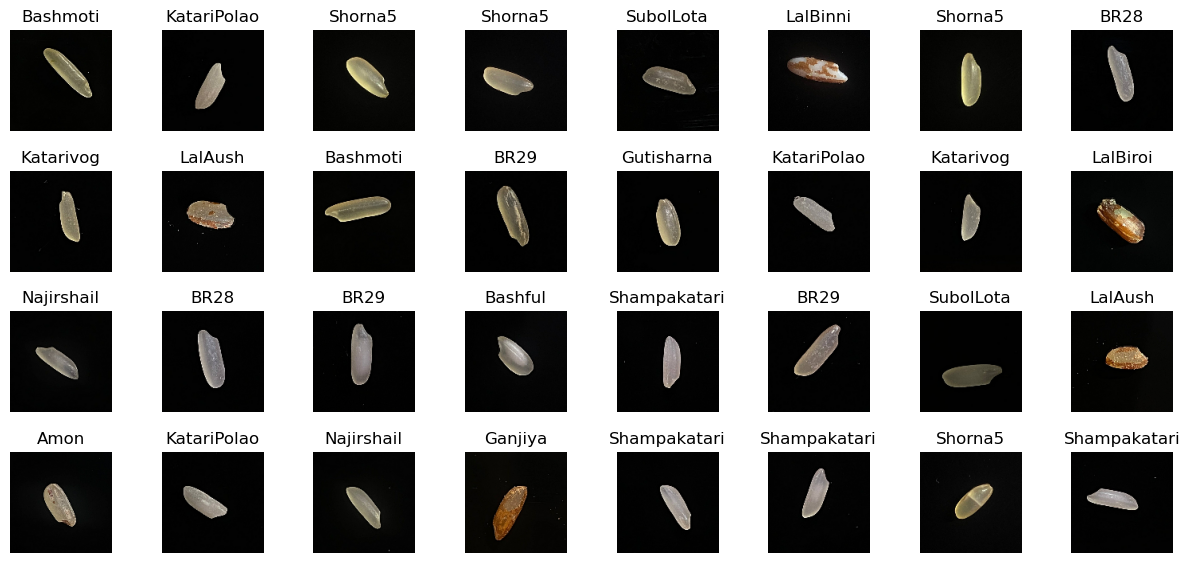

In [14]:
# visualization train data

plt.figure(figsize=(15,7))
for batch, label in train_df:
    for j in range(len(batch)):
        ax = plt.subplot(4,8,j+1)
        plt.imshow(batch[j])
        plt.title( "".join(classes[label[j]].split("_")[1:]))
        plt.axis('off')

    break
plt.subplots_adjust(wspace=0.5, hspace=0.2)

In [26]:
# Check for data leakage to ensure that we are not overlapping values across dataframes
train = []
for i in train_image_paths.as_numpy_iterator():
    train.append(i)

valid = []
for i in valid_image_paths.as_numpy_iterator():
    valid.append(i)

test = []
for i in test_image_paths.as_numpy_iterator():
    test.append(i)

print(list(filter(lambda x: x in train, valid)))
print(list(filter(lambda x: x in train, test)))
print(list(filter(lambda x: x in test, valid)))

[]
[]
[]


2024-08-15 16:59:34.412056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-15 16:59:34.461791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-15 16:59:34.514215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


______
______
______

# Model

In [13]:
# Model

inputs = tf.keras.Input(shape=(image_height, image_width, channels))

# hl = tf.keras.layers.Rescaling(1/255)(inputs)

hl = tf.keras.layers.RandomFlip(mode="vertical")(inputs)
hl = tf.keras.layers.RandomFlip(mode="horizontal" )(hl)
hl = tf.keras.layers.RandomContrast( factor=0.1 )(hl)

hl = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5))(hl)
hl = tf.keras.layers.BatchNormalization()(hl)
hl = tf.keras.layers.Activation("relu")(hl)
hl = tf.keras.layers.Dropout(0.5)(hl)

hl = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3))(hl)
hl = tf.keras.layers.BatchNormalization()(hl)
hl = tf.keras.layers.Activation("relu")(hl)
hl = tf.keras.layers.Dropout(0.5)(hl)

hl = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3))(hl)
hl = tf.keras.layers.BatchNormalization()(hl)
hl = tf.keras.layers.Activation("relu")(hl)
hl = tf.keras.layers.Dropout(0.5)(hl)

hl = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(hl)
hl = tf.keras.layers.BatchNormalization()(hl)
hl = tf.keras.layers.Activation("relu")(hl)
hl = tf.keras.layers.Dropout(0.5)(hl)

hl = tf.keras.layers.GlobalMaxPooling2D()(hl)


outputs = tf.keras.layers.Dense(units=len(classes), activation="softmax")(hl)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

run_name = datetime.datetime.now().strftime("(%Y-%m-%d %H:%M:%S)")

callbacks = [
    # tensorboard --logdir=artifacts/logs
    tf.keras.callbacks.TensorBoard(
        log_dir = os.path.join(".", "artifacts", "logs", run_name)
    ),
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_accuracy", 
    #     patience=60, 
    #     start_from_epoch=30, 
    #     restore_best_weights=False,
    #     verbose=1,
    # ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(".", "artifacts", "logs", run_name, "model.keras"),
        monitor="val_accuracy",
        save_best_only=True,
    ),
]

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 120, 120, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 120, 120, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 118, 118, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 118, 118, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 118, 118, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 118, 118, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         2,58

 Total params: 405,182 (1.55 MB)

 Trainable params: 134,868 (526.83 KB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 269,738 (1.03 MB)

In [14]:
model.fit(
    train_df, 
    validation_data=valid_df, 
    epochs=500,
    callbacks = [callbacks],
    verbose=0
)

I0000 00:00:1723638837.588916   18218 service.cc:145] XLA service 0x7f50a80044d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723638837.588972   18218 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1723638837.588977   18218 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-14 16:03:57.707715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-14 16:03:58.169474: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1723638853.368345   18218 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


___________
___________
___________

# Evaluate the best model on test data

In [15]:
model = tf.keras.models.load_model("/home/forvest/projects/mahdi_amin/vision/classification/rice/artifacts/logs/(2024-08-14 14:40:16)/model.keras")

In [17]:
loss, accuracy = model.evaluate(test_df, verbose=0)
print(f"Accuracy: {round(accuracy*100, 2)}%")
print(f"Loss: {round(loss, 6)}")

Accuracy: 97.73%
Loss: 0.08946


In [18]:
preds = tf.argmax(model.predict(test_df), axis=1)
y_actual = []

for _, label in test_df:
    y_actual += list(label.numpy())

# calculate confusion matrix
cm = tf.math.confusion_matrix(labels=y_actual, predictions=preds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


2024-08-15 16:55:30.299103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


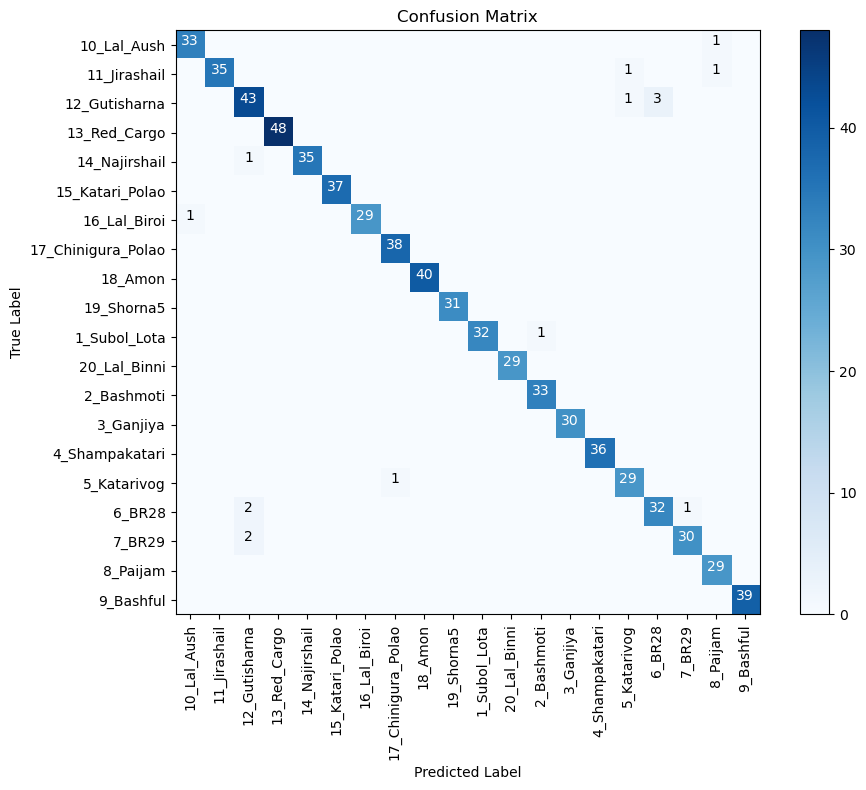

In [19]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the axes
class_names = classes  # Example class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# Add the text annotations
thresh = cm.numpy().max() / 2.
for i, j in np.ndindex(cm.numpy().shape):
    plt.text(j, i, f'{ cm[i, j] if cm[i, j]>0 else ""  }', 
             horizontalalignment="center", 
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

plt.show()